In [17]:
# Source:
# http://blog.nextgenetics.net/?e=102
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
body {background-color: rgba(192, 255, 238, 0.3) !important;}
</style>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Initialize the environment
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
sns.set(style="darkgrid")

In [3]:
sales = pd.read_csv(
    "https://raw.githubusercontent.com/rjstange/video-game-sales-by-rating/master/Video_Games_Sales_as_at_22_Dec_2016.csv"
)

In [4]:
na_sales_e_to_m_since_2003 = sales.loc[  # Only pull from entries 
    (sales["NA_Sales"] > 0)  # Where there are US sales
    & sales.Rating.notnull()  # Where there is a rating
    & (sales["Rating"] != "AO")  # Excluding limited observations
    & (sales["Rating"] != "EC")
    & (sales["Year_of_Release"] >= 2003),  # Released in 2003+
    [
        "Name",
        "Genre",
        "Year_of_Release",
        "NA_Sales",
        "Rating",
    ],
]

In [5]:
def pointplot(xarray, yarray, df, xorder):
    sns.set(
        rc={"figure.figsize": (28, 15)}  # Set figure size
    )  
    ax = sns.pointplot(
        x=xarray,
        y=yarray,
        data=df,
        join=False,
        order=xorder,
        scale=2,
    )           # Format yticks to be in hundreds of thousands
    ylabels = ['{:,.0f}K'.format(y) for y in ax.get_yticks() * 1000]
    ax.set_yticklabels(ylabels)
    plt.xlabel("\n{}\n".format(xarray), fontsize=30)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=20)
    plt.ylabel("Sales\n", fontsize=30)
    plt.title("\nUnits Sold\n", fontsize=42, fontweight=600)
    
    sns.set_context("talk");  # Make it more presentable

<center><h1>US Video Game Sales in Relation to Maturity Rating and Genre
<h2>Riley Stange
<h3>October 8, 2019

<center><h2>Overview</h2>

<img alt="vidya" class="article__featured-image article__featured-image--block breakout" sizes="(max-width: 730px) 100vw, (max-width: 1600px) 75vw, 1390px" src="https://techcrunch.com/wp-content/uploads/2015/10/vidya.jpg?w=730&amp;crop=1" srcset="https://techcrunch.com/wp-content/uploads/2015/10/vidya.jpg?w=400&amp;crop=1 400w, https://techcrunch.com/wp-content/uploads/2015/10/vidya.jpg?w=730&amp;crop=1 730w, https://techcrunch.com/wp-content/uploads/2015/10/vidya.jpg?w=990&amp;crop=1 990w, https://techcrunch.com/wp-content/uploads/2015/10/vidya.jpg?w=1390&amp;crop=1 1390w">
<br>
<strong>Image Credits: </strong><a href="http://www.shutterstock.com/gallery-891097p1.html" target="_blank">karnoff / <a href="http://www.shutterstock.com" target="_blank">Shutterstock 

- At present day, the global market for Video Games is a $100 billion industry
- What does it take to get a piece of that massive pie?
- I asked myself this question: Does a Video Game's maturity rating impact sales?
- Does the genre have an impact as well?
- If so, by how much on average?

<h2><center>Understanding ESRB's Ratings

- First I will give some background on the ESRB
- According to Wikipedia:
- ESRB stands for: Entertainment Software Rating Board. Established in 1994 by the Entertainment Software Association, in response to criticism of controversial video games with excessively violent or sexual content.


- E rated games are like G rated films, usually the violence is comical and slapstick like Looney Toons, and no other suggestive content
- E10+ is like PG: the violence can get a bit more intense, but there is still no blood


- T is like PG-13, where blood starts to show up, and more suggestive themes begin to creep in
- M is like R-rated, where the violence reaches a very intense, realistic level, as well as the introduction of sexual content, and very strong language

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E.svg" width="100" height="170" /><br>Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E10plus.svg" width="100" height="170" /><br>Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/T.svg" width="100" height="170" /><br>Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language.<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/M.svg" width="100" height="170" /><br>Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

## Overview: M-Rated Video Games performance in recent years

- In my research, I have found, from 2003-2016, M-Rated Video Games have been #2
- With 669+ million in total number of games sold
- Second only to games of the E-Rating at a little over a billion

In [6]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .groupby(na_sales_e_to_m_since_2003["Rating"])
    .agg("sum")
)

Rating
E       1045.20
E10+     345.50
M        669.38
T        590.91
Name: NA_Sales, dtype: float64


<center><h2>Sales Trends 2003-2016

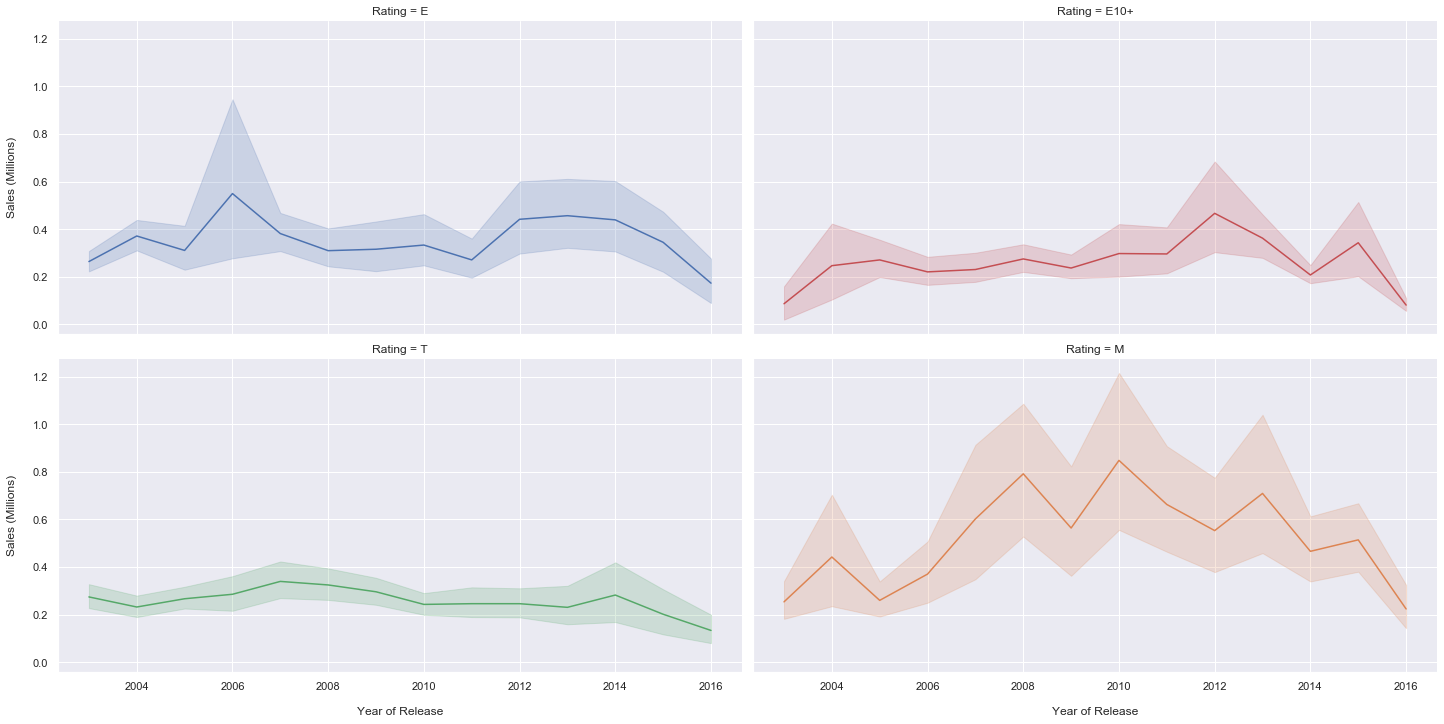

In [7]:
ax = sns.relplot(
    x="Year_of_Release",
    y="NA_Sales",
    hue="Rating",
    col="Rating",
    col_order=["E", "E10+", "T", "M"],
    col_wrap=2,
    height=5,
    aspect=2,
    kind="line",
    data=na_sales_e_to_m_since_2003,
    legend=False,
)
ax.set(xlabel="\nYear of Release", ylabel="Sales (Millions)\n")
sns.set_context("talk")
plt.show()

- Since 2007 M-Rated games have been dominant in unit sales
- Surprisingly, Teen games show a pretty flat, slightly declining trend. Could this be due to their target audience having to ask their parents to buy the game, at an age where many are less likely to shell out the cash to their children without something in return?
- It would be interesting to gather more data at a later time to investigate what happened with the downward trend starting in 2010, as this data cuts off at 2016
- Now, is there a statistically significant difference in average sales, as opposed to the trend of total sales?

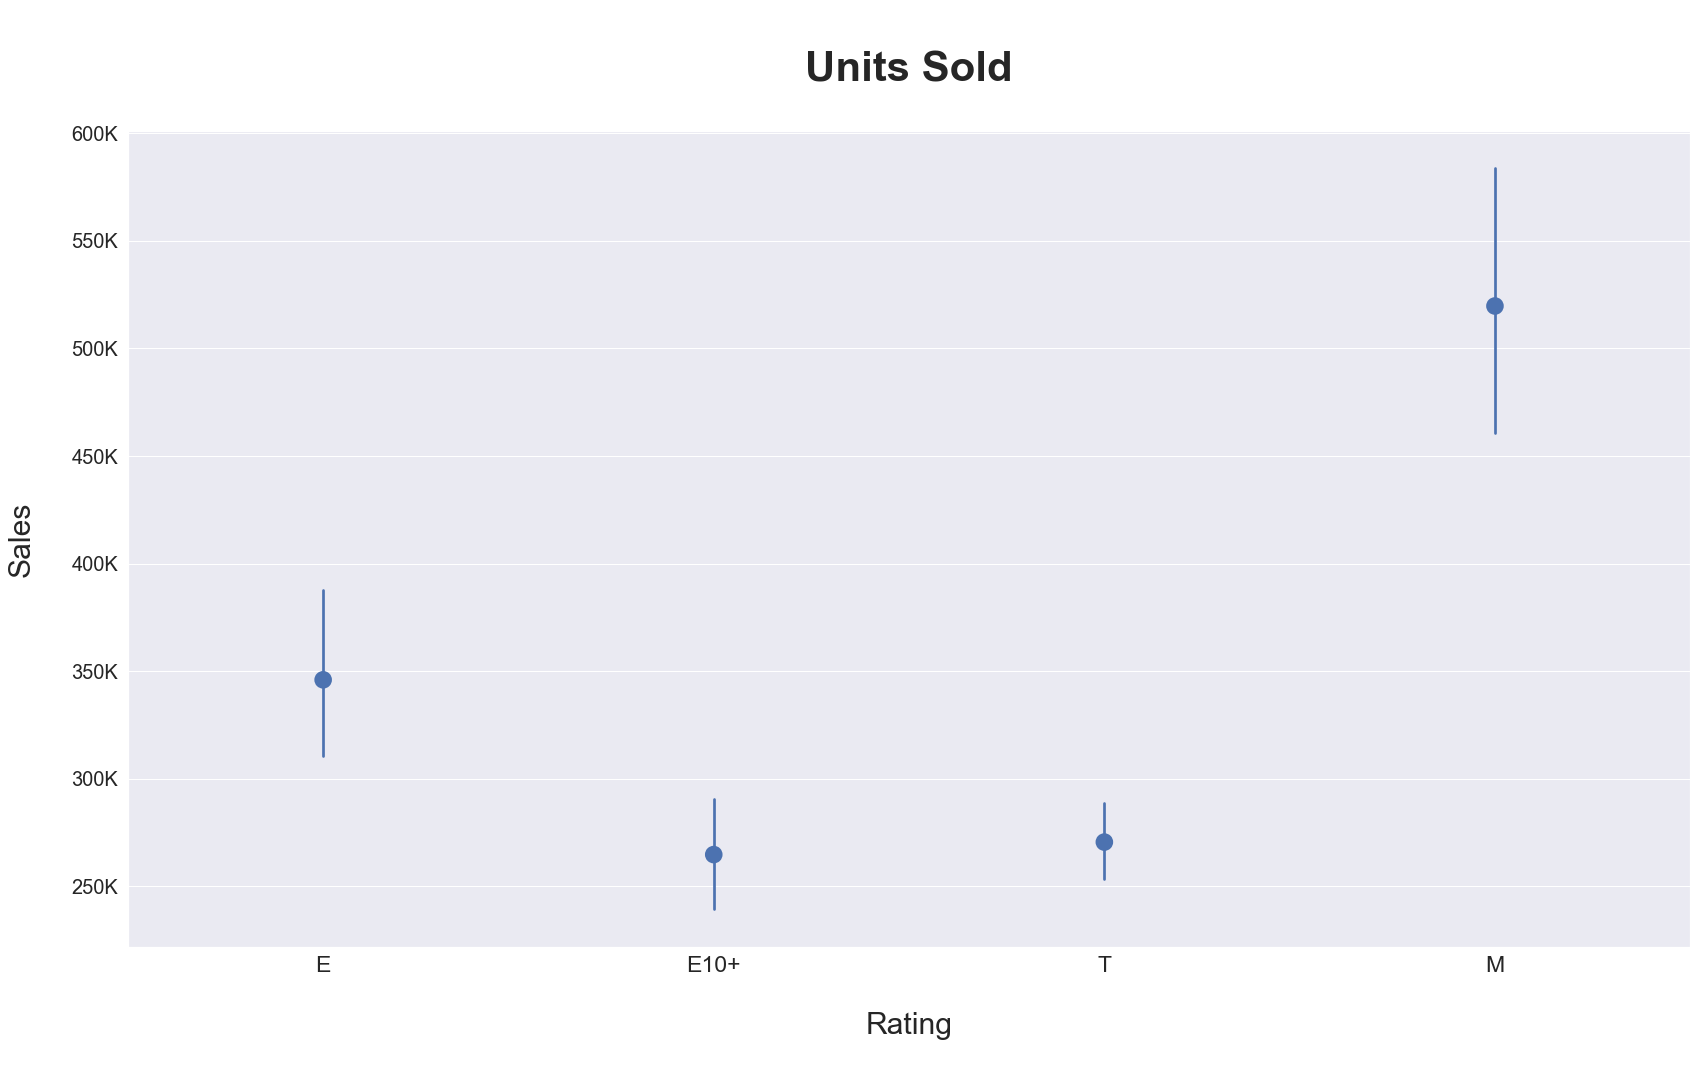

In [8]:
pointplot(
    "Rating",
    "NA_Sales",
    na_sales_e_to_m_since_2003,
    ["E", "E10+", "T", "M"],
)

- This shows a somewhat similar pattern to the previous graph of sales trend over time
- Mature rated games have the greatest range that they can sell at, but the lower and higher end of the range is at a much higher place, averaging at about 520K units
- And further statistical analysis shows...

In [9]:
print(
    "Moon's Median: {}".format(
        stats.median_test(
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "M"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "T"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "E10+"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "E"
            ],
        )
    )
)
print(
    "Kruskal-Wallis: {}".format(
        stats.kruskal(
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "M"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "T"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "E10+"
            ],
            na_sales_e_to_m_since_2003["NA_Sales"].loc[
                na_sales_e_to_m_since_2003["Rating"] == "E"
            ],
        )
    )
)

Moon's Median: (28.98066010576416, 2.2604823967600366e-06, 0.14, array([[ 698,  992,  593, 1439],
       [ 590, 1192,  712, 1582]], dtype=int64))
Kruskal-Wallis: KruskalResult(statistic=53.641830844538006, pvalue=1.3378189706515518e-11)


In [10]:
tukey_rating = pairwise_tukeyhsd(  # Tukey HSD for where I got my following figures from
    endog=na_sales_e_to_m_since_2003["NA_Sales"],  # Data
    groups=na_sales_e_to_m_since_2003["Rating"],  # Groups
    alpha=0.05, # Significance level
)
tukey_rating.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0812,0.025,-0.1553,-0.0072,True
E,M,0.1737,0.001,0.0993,0.2481,True
E,T,-0.0754,0.011,-0.1382,-0.0126,True
E10+,M,0.255,0.001,0.1671,0.3428,True
E10+,T,0.0058,0.9,-0.0724,0.0841,False
M,T,-0.2491,0.001,-0.3277,-0.1706,True


## With 95% Confidence, M-Rated video games sell more on average than games of another rating

- There is indeed a significant difference in sales between Mature rated games and games of other ratings


- 173k more on average than E rated


- 255k more on average than E10+ rated


- and 249k more on average than T rated

- Between 99k-248k units more than E rated

- 167k-342k more than E10+ rated

- 170k-327k more than T rated

## On Average, Mature Rated Games Sell Better...

- It's obvious that games with a Mature rating perform better on average than others
- But it's important to now hone in on the best performing genres

## But in what Genres?

In [11]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .loc[na_sales_e_to_m_since_2003["Rating"] == "M"]
    .groupby(na_sales_e_to_m_since_2003["Genre"])
    .agg("sum")
)

Genre
Action          241.16
Adventure        16.63
Fighting         14.64
Misc              1.92
Platform          0.24
Racing            1.76
Role-Playing     73.29
Shooter         313.89
Simulation        0.67
Sports            2.57
Strategy          2.61
Name: NA_Sales, dtype: float64


## Since 2003 Mature Rated Games sold most in the following genres:

- This figure of 313 million in sales is no surprise, as Mature rated games basically started out in this genre, with players toting around high powered guns and explosives, shooting up people and monsters up in a very immersive, visceral experience.


- 241 million in sales makes sense as well, as many Action games are very centered on hacking and slashing enemies, and perhaps realistic violence adds to the experience for some.


- A distant third at 73 million, Role-Playing games just describe that the player is building their character and watching them grow and develop throughout their gameplay. These games can have Action and/or Shooter gameplay elements.

- Shooter: 313 million+

- Action: 241 million+

- Role-Playing: 73 million+

## This seems to go along with intuition...

- With that in mind, let's plot the three based on how each game sells on average in each genre, still rated Mature.

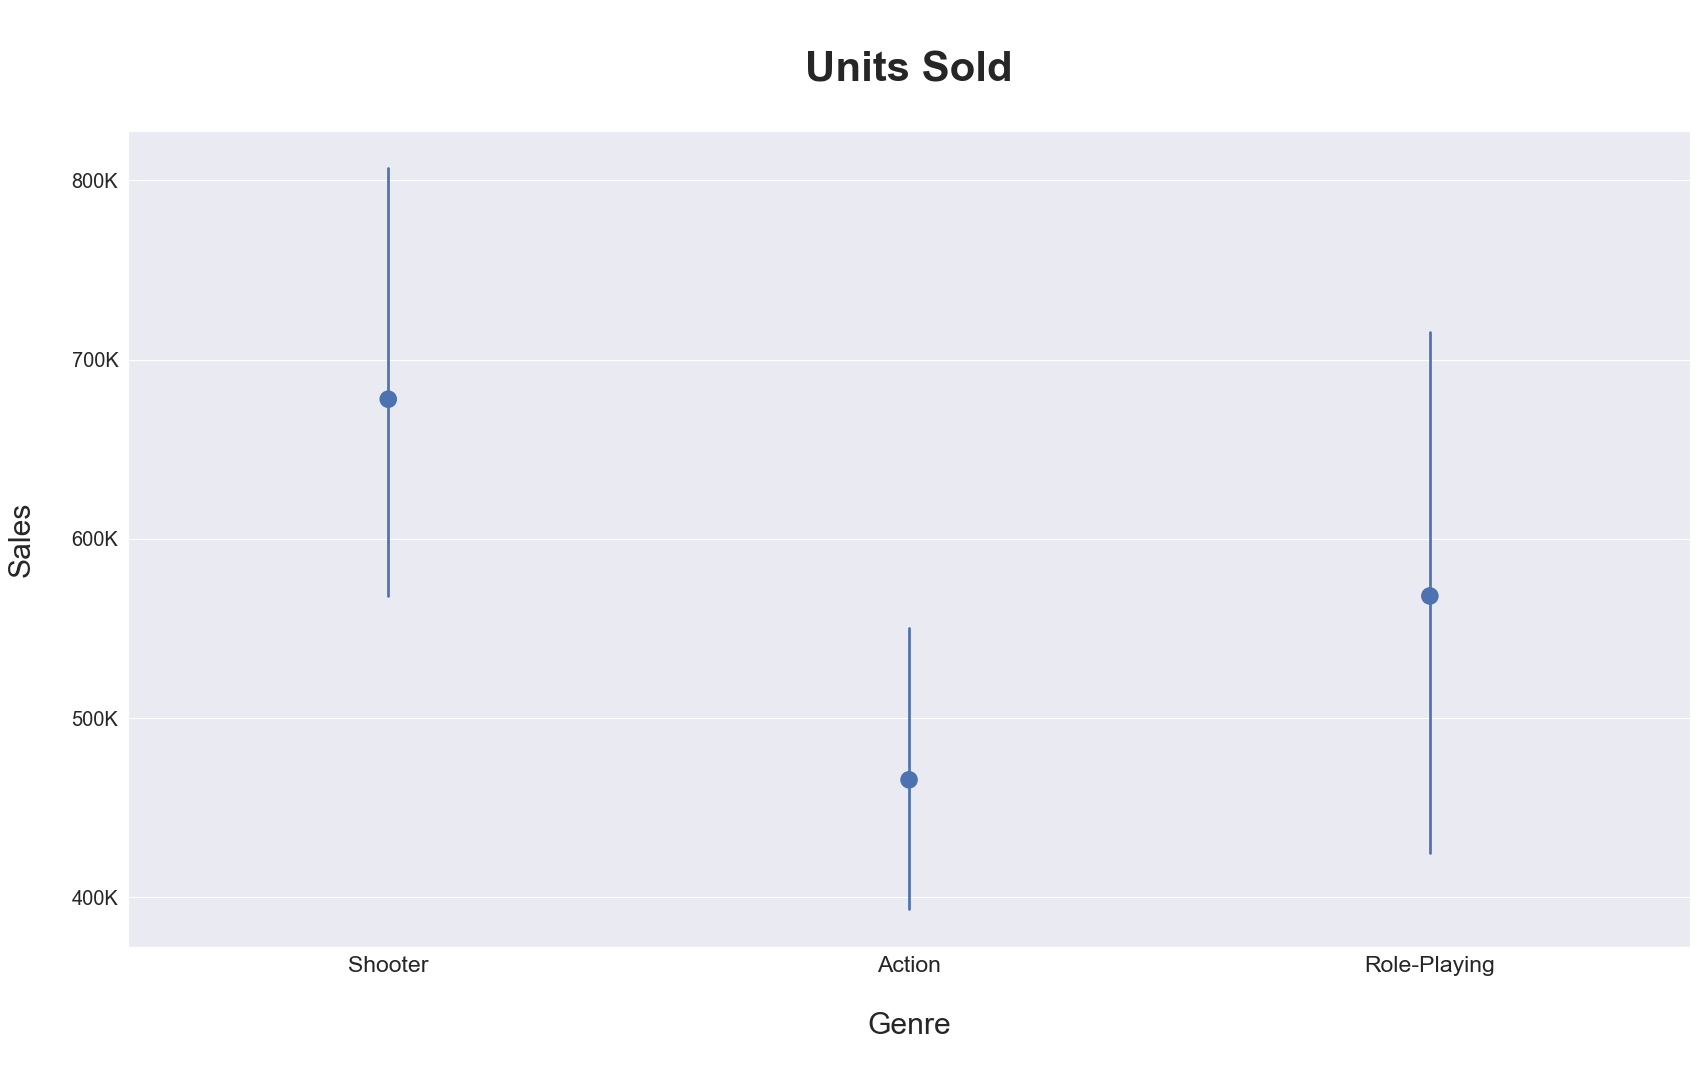

In [12]:
mature = na_sales_e_to_m_since_2003.loc[
    (na_sales_e_to_m_since_2003["Rating"] == "M")
    & (
        (na_sales_e_to_m_since_2003["Genre"] == "Shooter")
        | (na_sales_e_to_m_since_2003["Genre"] == "Action")
        | (na_sales_e_to_m_since_2003["Genre"] == "Role-Playing")
    ),
    ["NA_Sales", "Genre"],
]
pointplot(
    xarray="Genre",
    yarray="NA_Sales",
    df=mature,
    xorder=["Shooter", "Action", "Role-Playing"],
)

- No surprise with Shooters, but Role-Playing games?
- Looks can be deceiving...

## M-Rated Role-Playing games compared to Shooter and Action games

- Now, what do the stats have to say?

In [13]:
stats.median_test(
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Role-Playing"],
)

(4.240676658052763, 0.1199910251964748, 0.19, array([[245, 240,  64],
        [218, 278,  65]], dtype=int64))

In [14]:
stats.kruskal(
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Role-Playing"],
)

KruskalResult(statistic=4.799639238651511, pvalue=0.0907343185309352)

## Descriptive statistics shows:

- I found, after testing, no significant difference in each game's sale on average when comparing all three groups
- This may have something to do with the inclusion of the Role-Playing genre, as Mature rated Role-Playing Games's generally have Action and/or Shooter elements, probably contributing to this lack of difference in average sales.

## M-Rated Shooters compared to Action games

- But when we take M-Rated Role-Playing Games out of the equation
- That's another story

## With 95% confidence, M-Rated Shooters sell between 65k+ and 359k+ more units.

- Back to the tests
- With the Shooters selling 212K more units on average than Action games.

In [15]:
tukey_mature = pairwise_tukeyhsd(
    endog=mature["NA_Sales"],  # Data
    groups=mature["Genre"],  # Groups
    alpha=0.05, # Significance level
)
tukey_mature.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Role-Playing,0.1026,0.6118,-0.1563,0.3615,False
Action,Shooter,0.2124,0.0088,0.0441,0.3807,True
Role-Playing,Shooter,0.1098,0.5809,-0.1522,0.3718,False


In [16]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = np.sqrt(
        (sample_1_var / sample_1_n)
        + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between {} and {}.".format(
            ci_lower, 
            ci_upper,
        )
    )
get_95_ci(
    mature["NA_Sales"].loc[mature["Genre"] == "Action"],
    mature["NA_Sales"].loc[mature["Genre"] == "Shooter"],
)

'The difference in means at the 95% confidence interval (two-tail) is between 0.06532778637675712 and 0.3594488507972881.'

## Why are M-Rated Shooters More Successful than Action games?

- Now we are left with the ubiquitous question: "Why?"
- I have a few ideas
- Shooter games are fairly intuitive to pick up and play, while Action games can have more of a learning curve and more complex gameplay mechanics
- Action games have a lot more titles in other ratings
- It is harder for a Shooter to be successful if it is not M-Rated, so there are just more examples of them

## In Conclusion

- Keep in mind, my target audience for this research is either a video game studio or publishing company, both parties that can significantly impact the success of a video game, through a combination of quality work and effective marketing.
- Understanding how to have good talent in both making and marketing a game is simply a matter of seeing the quality of their past work. 
- With over 20 years of experience in video games, I have seen poorly marketed masterpieces, and over-marketed time-wasters.
- The best thing you can do is have great marketing, and great talent, and give them both room to innovate while not veering too far off what makes a certain type of game successful.

- Mature Rated Video Games are a safer investment of capital and development time

- More specifically, Shooters sell better on average than Action games if M-Rated

- M-Rated Role-Playing games are a smaller (potentially newer) market, but promising

- Success depends on other factors, such as developer talent, and effective marketing

<center><h2>Questions?
<img src="https://media.giphy.com/media/grZWJbqSikp3y/200w.gif">